# Machine learning headline analysis to predict daily stock movement
## Goal
When do we buy and sell stocks for profit

## Stratergy
1. Every day news headlines are read in and stored
2. at the end of the day for each stock it is predicted whether it will close higher than it opened tomorrow
3. sell stocks that will close lower and buy stocks that will close higher

## Approaches
1. Bag-of-words machine learning model trained on historical data
2. Spark clustering/continues learning trained on historical data
3. mix of sources (reddit, twitter, abc)
4. combination of headlines and traditional algorithms

## Finding accurate stocks
1. for each ticker in asx.csv extract label and attach to headlines
2. train model and evaluate

## Data Exploration

In [1]:
import pandas as pd

#historical abc new headlines
abc = pd.read_csv('abcnews-date-text.csv')

In [2]:
print(abc.shape)
print(abc.head)

(1186018, 2)
<bound method NDFrame.head of          publish_date                                      headline_text
0            20030219  aba decides against community broadcasting lic...
1            20030219     act fire witnesses must be aware of defamation
2            20030219     a g calls for infrastructure protection summit
3            20030219           air nz staff in aust strike for pay rise
4            20030219      air nz strike to affect australian travellers
...               ...                                                ...
1186013      20191231  vision of flames approaching corryong in victoria
1186014      20191231  wa police and government backflip on drug amne...
1186015      20191231  we have fears for their safety: victorian premier
1186016      20191231                              when do the 20s start
1186017      20191231  yarraville shooting woman dead man critically ...

[1186018 rows x 2 columns]>


In [41]:
#historical axjo data
stocks = pd.read_csv('1997-2017.csv')
stocks = stocks.dropna(how='any',axis=0) 

In [42]:
print(stocks.shape)
print(stocks.head)

(681540, 7)
<bound method NDFrame.head of        Ticker         Day   Open   High     Low  Close   Volume
0         AAD   2/01/1997   0.74   0.76   0.740   0.75    10722
1         ABC   2/01/1997   1.70   1.71   1.700   1.70    70000
2         AGL   2/01/1997   7.02   7.20   7.000   7.20   161097
3         ALL   2/01/1997   3.20   3.27   3.200   3.25    29600
4         AMC   2/01/1997   7.96   8.08   7.950   8.06   268106
...       ...         ...    ...    ...     ...    ...      ...
681535    WOW  29/12/2017  27.42  27.42  27.255  27.30  1208302
681536    WPL  29/12/2017  33.08  33.23  32.960  33.08  1629747
681537    WSA  29/12/2017   3.25   3.30   3.240   3.24  1455704
681538    WTC  29/12/2017  14.25  14.25  14.040  14.15   361716
681539    XRO  29/12/2017  28.19  28.83  28.010  28.66    68400

[681540 rows x 7 columns]>


In [51]:
stocks["Ticker"].nunique()

225

In [31]:
import numpy as np
stocks['Label'] = (stocks['Close'] < stocks.shift(periods=-1)['Open']).astype(int)
stocks.drop(stocks.tail(1).index,inplace=True)

<AxesSubplot:>

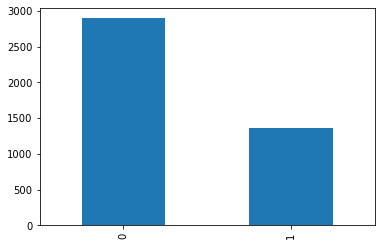

In [32]:
import matplotlib.pyplot as plt
stocks["Label"].value_counts().plot(kind='bar')

## Data Preprocessing

In [52]:
stocks.groupby("Ticker")

In [58]:
for ticker, stock in stocks.groupby("Ticker"):
    print(stock.shape)

(697, 7)
(4125, 7)
(2387, 7)
(5299, 7)
(3774, 7)
(1030, 7)
(3857, 7)
(3253, 7)
(1233, 7)
(891, 7)
(3768, 7)
(5279, 7)
(1577, 7)
(3478, 7)
(5300, 7)
(4937, 7)
(3956, 7)
(5301, 7)
(2362, 7)
(4421, 7)
(5127, 7)
(794, 7)
(135, 7)
(1746, 7)
(794, 7)
(1423, 7)
(4780, 7)
(926, 7)
(4849, 7)
(3798, 7)
(1282, 7)
(834, 7)
(931, 7)
(560, 7)
(5299, 7)
(1608, 7)
(5302, 7)
(5179, 7)
(4886, 7)
(4500, 7)
(933, 7)
(4353, 7)
(5250, 7)
(2215, 7)
(3886, 7)
(4863, 7)
(2798, 7)
(4532, 7)
(1074, 7)
(5296, 7)
(5288, 7)
(4126, 7)
(1406, 7)
(3529, 7)
(2898, 7)
(1588, 7)
(1545, 7)
(5295, 7)
(5288, 7)
(1966, 7)
(5290, 7)
(5288, 7)
(1819, 7)
(5304, 7)
(2545, 7)
(484, 7)
(30, 7)
(1891, 7)
(3135, 7)
(4165, 7)
(2480, 7)
(684, 7)
(774, 7)
(1545, 7)
(4078, 7)
(5263, 7)
(3608, 7)
(3793, 7)
(2786, 7)
(1844, 7)
(1192, 7)
(2627, 7)
(4889, 7)
(2066, 7)
(5273, 7)
(255, 7)
(5300, 7)
(1802, 7)
(2394, 7)
(2486, 7)
(3803, 7)
(870, 7)
(5268, 7)
(4022, 7)
(2574, 7)
(2444, 7)
(3549, 7)
(4011, 7)
(4689, 7)
(301, 7)
(805, 7)
(2296, 7)

In [7]:
#convert dates to match
stocks['Date'] = pd.to_datetime(stocks['Date'])
abc['publish_date'] = pd.to_datetime(abc['publish_date'], format='%Y%m%d')

#trim dataframes to the same time period
end_date = stocks['Date'].max()
start_date = stocks['Date'].min()

if abc['publish_date'].max() < end_date:
    end_date = abc['publish_date'].max()
    
if abc['publish_date'].min() > start_date:
    start_date = abc['publish_date'].min()

abc_mask = ((abc['publish_date'] > start_date) & (abc['publish_date'] <= end_date))
    
axjo_mask = ((axjo['Date'] > start_date) & (axjo['Date'] <= end_date))
    
abc = abc.loc[abc_mask]

axjo = axjo.loc[axjo_mask]

abc.rename(columns = {'publish_date':'Date'}, inplace=True)

In [10]:
#combine all headlines on the same day
abc = abc.groupby(['Date'])['headline_text'].apply(' '.join)

Date
2003-02-20    15 dead in rebel bombing raid philippines army...
2003-02-21    accc too timid in petrol price investigations ...
2003-02-22    86 confirmed dead after us nightclub fire act ...
2003-02-23    accused people smuggler to face darwin court a...
2003-02-24    94 dead in china earthquake academic considers...
                                    ...                        
2019-12-27    abc pic of the week best of 2019 alexei navaln...
2019-12-28    acosia red elk demonstrating jingle dress danc...
2019-12-29    alcohol addiction made me a drug dealer and se...
2019-12-30    aerial firefighting over bundoora african swin...
2019-12-31    abc reporter liv casben had to seek shelter at...
Name: headline_text, Length: 6151, dtype: object

In [14]:
#attach labels to headlines
df = pd.merge(abc, axjo[['Date','Label']], on='Date')
del df['Date']
df.head

<bound method NDFrame.head of                                             headline_text  Label
0          15 dead in rebel bombing raid philippines army      0
1                              abattoir up for sale again      0
2           academic upbeat about higher education review      0
3           administrator to be appointed to land council      0
4         aec to declare if nt to lose parliamentary seat      0
...                                                   ...    ...
981420  vision of flames approaching corryong in victoria      0
981421  wa police and government backflip on drug amne...      0
981422  we have fears for their safety: victorian premier      0
981423                              when do the 20s start      0
981424  yarraville shooting woman dead man critically ...      0

[981425 rows x 2 columns]>

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

#bag of words for headline
count_vect = CountVectorizer()
data_counts = count_vect.fit_transform(
        df['headline_text'])

tf_transformer = TfidfTransformer(use_idf=False).fit(data_counts)
data_tf = tf_transformer.transform(data_counts)

X_train, X_test, y_train, y_test = train_test_split(
        data_tf,
        df['Label'],
        random_state = 42,
        stratify = df['Label'])

## Model Training

In [25]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss="modified_huber",
                    penalty="elasticnet",
                    max_iter=np.ceil(10**6 / 738255),
                    alpha=0.0001,
                    class_weight={1: 0.6, 0: 0.4},
                    eta0=10,
                    learning_rate='invscaling')

sgd.fit(X_train, y_train)

SGDClassifier(class_weight={0: 0.4, 1: 0.6}, eta0=10,
              learning_rate='invscaling', loss='modified_huber', max_iter=2.0,
              penalty='elasticnet')

## Model Evaluation

In [26]:
def evaluate(y_test, pred):
    print('---------------------------------------')
    print("Accuracy: ", metrics.accuracy_score(y_test, pred))
    
    #confusion matrix
    print("Confussion Matrix: ")
    print(metrics.confusion_matrix(y_test, pred))
    
    #Precision, recall, f-measures
    print("Precision, recall, f-measures: ")
    print(metrics.classification_report(y_test, pred))
    
    #Balanced accuracy
    print("Balanced accuracy: ", metrics.balanced_accuracy_score(y_test, pred))
    print('---------------------------------------')

In [27]:
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

sgd_predict = sgd.predict(X_test)
evaluate(sgd_predict, y_test)

---------------------------------------
Accuracy:  0.6516871334422902
Confussion Matrix: 
[[138101  60538]
 [ 24923  21795]]
Precision, recall, f-measures: 
              precision    recall  f1-score   support

           0       0.85      0.70      0.76    198639
           1       0.26      0.47      0.34     46718

    accuracy                           0.65    245357
   macro avg       0.56      0.58      0.55    245357
weighted avg       0.74      0.65      0.68    245357

Balanced accuracy:  0.5808793105135587
---------------------------------------


## Hyper parameter tuning

In [23]:
"""
loss = ['hinge', 'log', 'modified_huber', 'squared_hinge','perceptron']
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive'] 
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
eta0 = [1, 10, 100] 

param_distributions = dict(loss=loss,
                           penalty=penalty,
                           alpha=alpha, 
                           learning_rate=learning_rate, 
                           class_weight=class_weight, 
                           eta0=eta0) 

random = RandomizedSearchCV(estimator=sgd,
                            param_distributions=param_distributions,
                            scoring='roc_auc',
                            verbose=1, n_jobs=-1, 
                            n_iter=100) 

random_result = random.fit(X_train, y_train)

print('Best Score: ', random_result.best_score_) 
print('Best Params: ', random_result.best_params_)
"""

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.3min finished


Best Score:  0.6305537810553842
Best Params:  {'penalty': 'elasticnet', 'loss': 'modified_huber', 'learning_rate': 'invscaling', 'eta0': 10, 'class_weight': {1: 0.6, 0: 0.4}, 'alpha': 0.0001}


C:\Users\CameronScully\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
